In [6]:
using Random
using DataStructures
using Plots

using NBInclude
@nbinclude("dcj_algo.ipynb")

In [7]:
# returns dup char --> num instances dictionary, num of duplicate chars  
##### returns 2 x N array (N = num dup char) of duplicate char & num instances, num of duplicate chars

function find_dups_in_str(str::String)
    alphabet = Set{Char}() 
    duplicates = OrderedDict{Char, Int}()  # duplicate char --> num instances 

    for char in str
        char = lowercase(char)   
        if char in alphabet 
            if char in keys(duplicates)
                duplicates[char] += 1
            else 
                duplicates[char] = 2 
            end 
        else 
            push!(alphabet, char)
        end 
    end 

    return duplicates, length(duplicates) 
end 

find_dups_in_str (generic function with 1 method)

In [8]:
function generate_map(num_dups::Int, dup_to_num_instances::OrderedDict{Char, Int},  S_M_set::Set{Array{Int}})
    max_maps = 0 
    for (dup, num_instances) in dup_to_num_instances
        max_maps += factorial(num_instances)
    end 

    while true 
        if length(S_M_set) == max_maps
            throw(ArgumentError("Generated all possible maps already."))
        end 

        map = Array{Int}(undef, num_dups)
        
        idx = 1
        # for each position of the map (each gene w >1 instances)
        for (dup_char, num_instances) in pairs(dup_to_num_instances)
            # an integer value is selcted uniformly from the interval [0, occ(α, S)! -1] 
            mapidx_for_dup_char = rand(1:factorial(num_instances))
            
            map[idx] = mapidx_for_dup_char
            idx += 1
        end 
        if map ∉ S_M_set
            return map 
        end 
    end 
end 

# S = "aabc"
# S_dupchar_to_multiplicity, S_num_dups = find_dups_in_str(S)
# S_M_set = Set{Array{Int}}()
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
# push!(S_M_set, map)
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
# push!(S_M_set, map)
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set) # should throw error bc alr generated all possible maps

generate_map (generic function with 1 method)

In [9]:
# DP implementation of factorial
function Base.factorial(n::Int, factorials::Vector{Int})
    if n == 1 || n == 0 
        return 1
    end 

    if factorials[n] != 0  
        return factorials[n]
    else 
        fact =  n * factorial(n - 1, factorials)
        factorials[n] = fact
        return fact
    end 
end

# returns kth lexicogrpahical order of the first n ints 
# k ε [1,n!]
function nth_lex_permutation(n::Int, k::Int)
    k -= 1
    factorials = zeros(Int, 26)
        
    numbers = collect(1:n)
    permutation = Vector{Int}()

    for i in 1:n
        fact = factorial(n - i, factorials)
        index = div(k, fact)
        k %= fact

        push!(permutation, numbers[index+1])
        splice!(numbers, index+1)

    end
    
    return permutation
end


# n = 5  # num duplicates 
# k = 45  #  kth lexicogrpahical order of the first n ints [1:n!]

# perm = nth_lex_permutation(n, k)
# println(perm)

nth_lex_permutation (generic function with 1 method)

In [10]:
function new_char(alphabet::Set{Char})
    while length(alphabet) != 26 
        c = Char(rand('a':'z'))
        if c ∉ alphabet 
            push!(alphabet, c)
            return c
        end 
    end 
    throw(ArgumentError("Ran out of unique characters in the alphabet"))
    
end 

function convert_perm_to_ordered_unique_chars(dupchar::Char, dup_perm::Vector{Int}, dupchar_to_unique_char::Dict{Char, Vector{Char}})
    ordered_unique_chars = Vector{Char}()
    for i in dup_perm 
        push!(ordered_unique_chars, dupchar_to_unique_char[dupchar][i])
    end 
    return ordered_unique_chars
end 

function deduplicate_genome(map::Array{Int}, dup_genome::String, dupchar_to_multiplicity::OrderedDict{Char, Int}, dupchar_to_unique_char::Dict{Char, Vector{Char}})
    if dupchar_to_unique_char == Dict{Char, Vector{Char}}()  # passed in target genome; need to assign dup chars to unique chars
        alphabet = Set(dup_genome)
        
        # create mapping from duplicated chars (multiplicity k) --> [array of k unique chars], idx = idx of duplicate (referenced by permutation) 
        idx = 1
        for (dupchar, mult) in pairs(dupchar_to_multiplicity)
            unique_chars = [dupchar]
            for i in 2:dupchar_to_multiplicity[dupchar]
                c = new_char(alphabet)
                push!(unique_chars, c)
            end     
            dupchar_to_unique_char[dupchar] = unique_chars
            
            idx += 1
        end 
    end 
    
    # for each duplicated char, create the correct ordering of unique chars in deduplicated genome 
    # based on mapping from dup chars -> unique chars & lexicographical permutation
    idx = 1
    perm_to_ordered_unique_chars = Dict{Char, Vector{Char}}()
    for (dupchar, mult) in pairs(dupchar_to_multiplicity)
        # for each elem i in map, convert i --> ith permutation of k ints in lexicographical order (k = multiplicity) 
        dup_perm = nth_lex_permutation(mult, map[idx])  

        perm_to_ordered_unique_chars[dupchar] = convert_perm_to_ordered_unique_chars(dupchar, dup_perm, dupchar_to_unique_char)
        
        idx += 1
    end 

    # deduplicate the genome with the orderings generated above with the permutations for duplicate genes
    dedup_genome = Vector{Char}()
    for char in dup_genome
        if lowercase(char) in keys(dupchar_to_multiplicity)
            unique_char = perm_to_ordered_unique_chars[lowercase(lowercase(char))][1]
            if isuppercase(char) 
                unique_char = uppercase(unique_char)
            end 
            push!(dedup_genome, unique_char)

            splice!(perm_to_ordered_unique_chars[lowercase(char)], 1)
        else 
            push!(dedup_genome, char)
        end 
    end

    return join(dedup_genome)
end 


# P = "abbAac"
# P_dup_to_num_instances, P_num_dups = find_dups_in_str(P)
# P_map = generate_map(P_num_dups, P_dup_to_num_instances)
# dupchar_to_unique_char = Dict{Char, Vector{Char}}()

# deduplicate_genome(P_map, P, P_dup_to_num_instances, dupchar_to_unique_char)

deduplicate_genome (generic function with 1 method)

In [17]:
# mapping S --> T, generates r random maps (RM)
# mode options: "none", "info"
function randommap(S::String, P::String, num_maps::Int, mode::String)
    if mode == "info"
        m = 1
    else 
        m = 0 
    end 

    println("SRC ", S, " --> TARGET ", P, "\n")


    ## GENERATE MAPS  
    P_dupchar_to_multiplicity, P_num_dups = find_dups_in_str(P)
    S_dupchar_to_multiplicity, S_num_dups = find_dups_in_str(S)

    P_map = ones(Int, P_num_dups)

    if m >= 1
        printstyled("target", color=:magenta)
        println("\ndup genes --> multiplicity")
        println(P_dupchar_to_multiplicity, "\n")

        # arbitrary map p for target string 
        println("target map")
        print(P_map, "\n")
    end   

    S_M = Array{Array{Int}}(undef, num_maps)  
    S_M_set = Set{Array{Int}}()

    # r RM of src str S are generated and stored in a set S_M 
    if m >= 1
        printstyled("\nsource", color=:magenta)
        println("\ndup genes --> multiplicity")
        println(S_dupchar_to_multiplicity, "\n")
        println("source maps")
    end 
    for i in 1:num_maps
        s_map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
        S_M[i] = s_map
        push!(S_M_set, s_map)
        if m >= 1
            println(s_map)
        end 
    end 


    ## DEDUPICATION 
    if m >= 1
        printstyled("\ndeduplication\n", color=:magenta)
    end 
    dupchar_to_unique_char = Dict{Char, Vector{Char}}()

    P_dedup = deduplicate_genome(P_map, P, P_dupchar_to_multiplicity, dupchar_to_unique_char)
    if m >= 1
        println("deduplicated target ", P_dedup, "\n")
    end 

    S_dedup_list = Vector{String}()
    for s_map in S_M 
        s_dedup = deduplicate_genome(s_map, S, S_dupchar_to_multiplicity, dupchar_to_unique_char)
        push!(S_dedup_list, s_dedup)

        if m >= 1
            println("deduplicated source ", s_dedup)
        end 
    end 
   
    ## DCJ DISTANCE 
    dcj_dist_list = Vector{Int}()
    for s_dedup in S_dedup_list
        d = calculate_distance(P_dedup, s_dedup, "none")
        push!(dcj_dist_list, d)
    end

    print("\ndcj distances ", dcj_dist_list)
    return dcj_dist_list
    # return shortest map iwth shortest dist between permutations 
end 


# src = "aaAAaAbbbBbbccd"  # 6a, 6b, 2c, 1d
# target = "abcdabbaacbabab"
# num_maps = 100

src = "aaabbc"  # 6a, 6b, 2c, 1d
target = "baabca"
num_maps = 8

n = length(src)  # == length(target)

dcj_dist_list = randommap(src, target, num_maps, "info")

SRC aaabbc --> TARGET baabca

target
dup genes --> multiplicity
OrderedDict('a' => 3, 'b' => 2)

target map
[1, 1]

source
dup genes --> multiplicity
OrderedDict('a' => 3, 'b' => 2)

source maps
[5, 2]
[1, 2]
[2, 1]
[6, 2]
[3, 1]
[4, 1]
[4, 2]
[2, 2]

deduplication
deduplicated target baohcg

deduplicated source gaohbc
deduplicated source aoghbc
deduplicated source agobhc
deduplicated source goahbc
deduplicated source oagbhc
deduplicated source ogabhc
deduplicated source ogahbc
deduplicated source agohbc

dcj distances [2, 4, 4, 4, 2, 4, 4, 4]

8-element Vector{Int64}:
 2
 4
 4
 4
 2
 4
 4
 4

max dcj distance = 15

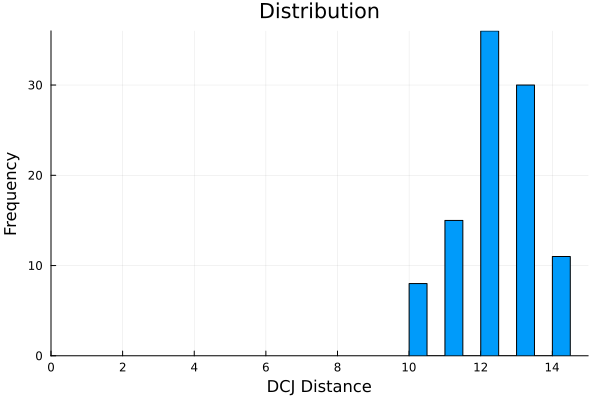

In [12]:
# ### visualization 

# # data = randn(1000)  # 1000 random values from a normal distribution
# data = dcj_dist_list

# max_value = n
# print("max dcj distance = ", n)

# # Create a range for x-ticks from 0 to max_value with a step of 2
# xticks = 0:2:max_value


# # Create a histogram
# histogram(data, title="Distribution", label="", xlabel="DCJ Distance", ylabel="Frequency",  xlims=(0, max_value), xticks=(xticks, xticks))

